Drive Link : https://drive.google.com/drive/folders/1l7qMCjm1OIfbQR8KPiz8v8z1kaIhbRca?usp=sharing

#### Name: Meher Shashwat Nigam
#### Roll: 20171062

In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Helper function to calculate error between projected point from estimated projection matrix and ground truth 

In [2]:
def calculate_error(X,P,x):
    calc_x = P @ X.T
    calc_x = calc_x/calc_x[2]
    return np.linalg.norm(x-calc_x)

### Helper Function to convert the Rotation Matrix into the Euler Angles


In [3]:
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
    R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
    R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R

# Question 1
## DLT, RANSAC

### Visualizing the image and finding correspondences manually

In [4]:
im = cv2.imread("./Camera_calibration_data/calib-object.jpg")
# cv2.namedWindow('image_window',cv2.WINDOW_NORMAL)
# cv2.imshow('image_window',im)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

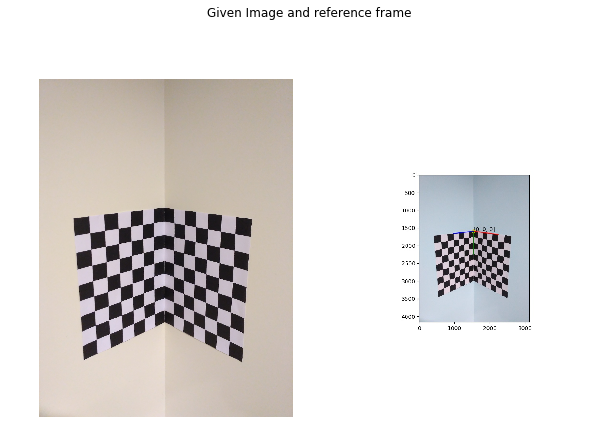

In [5]:
im = cv2.cvtColor(cv2.imread("./Camera_calibration_data/calib-object.jpg"),cv2.COLOR_BGR2RGB)
ref = cv2.cvtColor(cv2.imread("./Camera_calibration_data/calib-object-legend.jpg"),cv2.COLOR_BGR2RGB)
 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 7))
fig.suptitle('Given Image and reference frame')
ax1.imshow(im)
ax1.axis('off')
ax2.imshow(ref)
ax2.axis('off')
plt.show()

### Manually found world-image correspondences:

In [6]:
# 23 correspondences found
world_coordinates = np.array([[28,28,0],
                             [56,28,0],
                             [84,28,0],
                             [56,56,0],
                             [28,56,0],
                             [84,56,0],
                             [140,140,0],
                             [140,112,0],
                             [84,112,0],
                             [28,196,0],
                             [28,168,0],
                             [0,28,28],
                             [0,84,28],
                             [0,112,28],
                             [0,112,84],
                             [0,112,112],
                             [0,84,84],
                             [0,56,84],
                             [0,56,112],
                             [0,84,140],
                             [0,140,140],
                             [0,168,196],
                             [0,224,112]])
image_points = np.array([[1664,1783],
                         [1792,1806],
                         [1928,1831],
                         [1789,1982],
                         [1663,1953],
                         [1923,2013],
                         [2203,2640],
                         [2210,2458],
                         [1914,2363],
                         [1657,2752],
                         [1776,2648],
                         [1412,1780],
                         [1415,2116],
                         [1418,2279],
                         [1146,2356],
                         [997,2398],
                         [1143,2183],
                         [1137,2007],
                         [984,2036],
                         [831,2259],
                         [849,2625],
                         [698,3038],
                         [1026,3078]])

## DLT function definition


In [7]:
def calibrateDLT(world_points, camera_points):
    matrix = []
    for i in range(world_points.shape[0]):
        
        X = world_points[i][0]
        Y = world_points[i][1]
        Z = world_points[i][2]
        
        x = camera_points[i][0]
        y = camera_points[i][1]       
        
        row1 = [-X,-Y,-Z,-1,0,0,0,0,X*x,Y*x,Z*x,x]
        row2 = [0,0,0,0,-X,-Y,-Z,-1,X*y,Y*y,Z*y,y]

        matrix.append(row1)
        matrix.append(row2)
        
    u, s, Vh = np.linalg.svd(matrix)
    
    P = Vh[-1,:]
    P = Vh[-1,:] / Vh[-1,-1]
    P = P.reshape(3,4)
    return P

## Function to decompose the projection matrix to return camera matrix(K), Rotation matrix(R) and camera centre(x0)

In [8]:
def calculate_RTX(P):
    M = P[:,:3]
    p = P[:,3]
    x0 = -np.linalg.inv(M) @ p
    q,r = np.linalg.qr(np.linalg.inv(M))
    R = q.T
    K = np.linalg.inv(r)
    K = K/K[2][2]
    return K,R,x0

### Running the DLT function over all points

In [9]:
P = calibrateDLT(world_coordinates,image_points)
print("Projection Matrix:",P)
k,r,x = calculate_RTX(P)
print("Camera Matrix:",k)
print("Rotation Matrix:",r)
print("Camera Center:",x)

Projection Matrix: [[ 3.40574198e+00  4.57203514e-01 -5.68004163e+00  1.51898202e+03]
 [ 2.23855132e-02  6.17256852e+00 -6.16685589e-01  1.57757057e+03]
 [-6.41686904e-04  1.28225073e-04 -9.13157537e-04  1.00000000e+00]]
Camera Matrix: [[5.36925168e+03 4.60841484e+02 2.42458892e+03]
 [0.00000000e+00 5.41878207e+03 1.06194966e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix: [[-0.81263206  0.06085259  0.57959132]
 [-0.11561728 -0.99159938 -0.05799417]
 [ 0.57119329 -0.11413869  0.81284106]]
Camera Center: [ 626.56432186 -195.16786736  627.40156318]


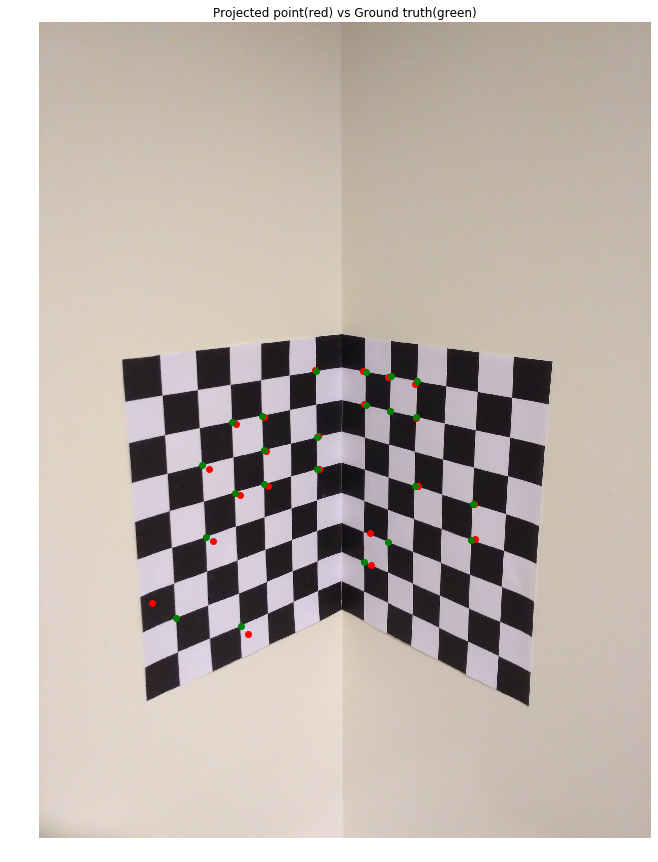

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(cv2.imread("./Camera_calibration_data/calib-object.jpg"),cv2.COLOR_BGR2RGB))
for i in range(world_coordinates.shape[0]):
    proj = P @ np.append(world_coordinates[i],1).T
    proj = proj/proj[2]
    cc = image_points[i]
    plt.plot(proj[0],proj[1], 'ro')
    plt.plot(cc[0],cc[1],'go')
plt.axis('off')
plt.title("Projected point(red) vs Ground truth(green)")
plt.show()    

## RANSAC function definition
#### Finds the set with most number of inlier points, in given number of iterations and a specified threshold

In [11]:
def RANSAC(world_points,image_points,threshold,iters,sample_size):
    ''' threshold : error value below which the point classifies as an inlier
        iters : number of times points are sampled and checked
        sample_size : number of points sampled each time
    '''
    total_pts = world_points.shape[0]
    max_inliers = 0
    best_err = 0
    P_best = np.zeros((3,4))
    for i in range(iters):
        sampling = np.random.choice(total_pts,sample_size)
        swp = world_points[sampling]
        sip = image_points[sampling]
        P_mat = calibrateDLT(swp,sip)
        
        inliers = 0
        sum_err = 0
        for j in range(total_pts):
            wp = np.append(world_points[j],1)
            cp = np.append(image_points[j],1)
            err = calculate_error(wp,P_mat,cp)
            sum_err+=err
            if(err<threshold):
                inliers+=1
                
        if inliers>max_inliers:
            max_inliers = inliers
            P_best = P_mat
            best_err = sum_err/total_pts
            
    return P_best,best_err,max_inliers      

### Running RANSAC over all points

In [12]:
P_best,err,inl = RANSAC(world_coordinates,image_points,10,100,6)
print("Projection matrix from the best set:",P_best)
print("Average projection error:",err)
print("Number of inlier points:",inl)
print(err,inl)
k,r,x = calculate_RTX(P_best)
print("Camera Matrix",k/k[2][2])
print("Rotation Matrix:",r)
print("Camera Center",x)

Projection matrix from the best set: [[ 2.44533031e+00  5.64259474e-01 -6.09178276e+00  1.53883336e+03]
 [-1.19279351e+00  6.61749073e+00 -1.07104981e+00  1.58954290e+03]
 [-1.13725156e-03  3.49941855e-04 -1.05342402e-03  1.00000000e+00]]
Average projection error: 16.978428261324254
Number of inlier points: 21
16.978428261324254 21
Camera Matrix [[3.85790434e+03 5.62980351e+00 1.51800778e+03]
 [0.00000000e+00 3.83980153e+03 1.90081487e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Matrix: [[-0.68020284 -0.00396644  0.73301321]
 [-0.158782   -0.97544615 -0.15262074]
 [ 0.71562027 -0.22020237  0.66287144]]
Camera Center [456.04538131 -88.81928505 427.44430163]


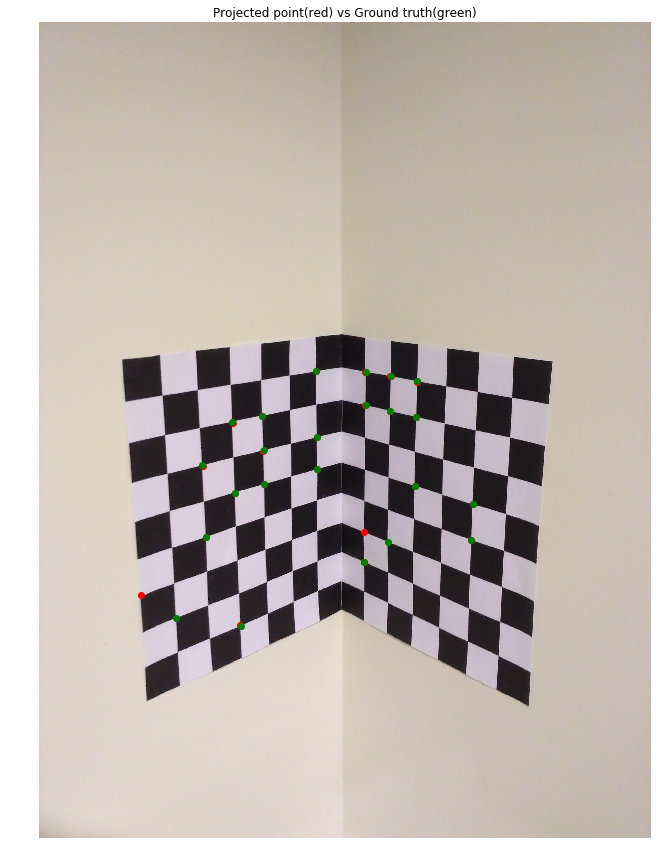

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(cv2.imread("./Camera_calibration_data/calib-object.jpg"),cv2.COLOR_BGR2RGB))
for i in range(world_coordinates.shape[0]):
    proj = P_best @ np.append(world_coordinates[i],1).T
    proj = proj/proj[2]
    cc = image_points[i]
    plt.plot(proj[0],proj[1], 'ro')
    plt.plot(cc[0],cc[1],'go')
plt.axis('off')
plt.title("Projected point(red) vs Ground truth(green)")
plt.show() 

### Observations on RANSAC :
- Error in projection has significantly reduced
- Points are mapping quite accurately
- Outlier points are rejected(seen separately as red points in the above image which arose from wrong measurement)


## Distortion Removal

In [14]:
# For distortion removal part, new image given
imgx = cv2.imread("./Camera_calibration_data/Fig1.png")

cp = np.load('./data/dist_pixel_coordinates.npy')
wp = np.load('./data/dist_world_coordinates.npy')

P_new,err,inl = RANSAC(wp,cp,7,100,6)
k_temp,r,x = calculate_RTX(P_new)
print("Camera Matrix",k_temp)


Camera Matrix [[ 3.58233328e+03 -1.66527831e+01  9.70487255e+02]
 [ 0.00000000e+00  3.56553809e+03  2.54999143e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Distortion Parameters :  [[-2.83300453e-01  1.09157098e+01 -4.19583356e-03 -3.81041726e-03
  -8.35092835e+01]]


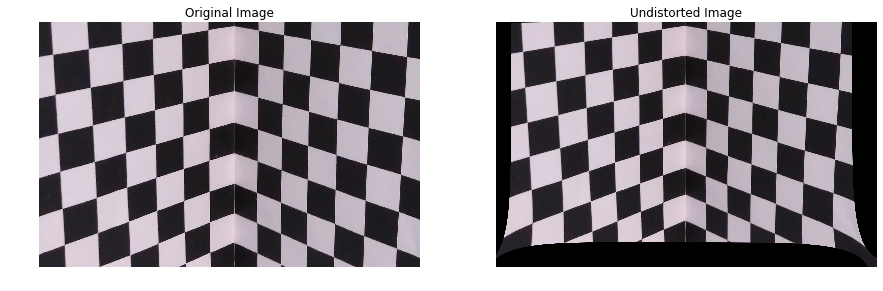

In [15]:
# Forcing shear = 0 for cameraCalibrate function
k_temp[0,1] = 0

ret, oldK, dist, rvecs, tvecs = cv2.calibrateCamera(np.array([wp]).astype(np.float32), 
                                                   np.array([cp]).astype(np.float32),
                                                   (imgx.shape[1],imgx.shape[0]),
                                                   k_temp,None, None,flags=(cv2.CALIB_USE_INTRINSIC_GUESS ))
print("Distortion Parameters : ", dist)

ht,wt = imgx.shape[:2]

newK,_ = cv2.getOptimalNewCameraMatrix(k_temp,dist,(wt,ht),1,(wt,ht))

I_undistort = cv2.undistort(imgx,oldK,dist,None,newK)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(imgx)
plt.axis('off')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(I_undistort)
plt.title('Undistorted Image')
plt.show()

### Observations:
The lines appear to be perfectly parallel and the squares appear to be of similar size now as radial distortion has been removed.


# Question 2
## Zhangs methods
The checkerboard corners are assumed to be unit scale.
Function stacks world points and image points from separate images together and passes it to cv2.calibrateCamera function to get camera matrix, distortion parameters and rotation/translation vectors for each image.

In [16]:
_3d_points=[]
_2d_points=[]
x,y=np.meshgrid(range(8),range(6))
world_points=np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)

for i in range(15):
    im=cv2.imread("./Camera_calibration_data/IMG_54"+str(56+i)+".JPG")
    
    ret, corners = cv2.findChessboardCorners(im, (8,6))
    
    if ret: #add points only if checkerboard was correctly detected:
        _2d_points.append(corners) 
        _3d_points.append(world_points) 

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)

Reprojection Error: 2.4810222497615952
Camera Calibration Matrix:
[[1.36634816e+04 0.00000000e+00 3.33651275e+03]
 [0.00000000e+00 1.36813888e+04 1.49657985e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 9.51409607e-02  1.01150408e+01 -1.52797290e-02  2.87204086e-02
  -1.60701382e+02]]


## Wireframe construction and overlay over all images

In [17]:
# Function gets the projection matrix from given K,R,t
def get_projection(K,r,t):
    R = (eulerAnglesToRotationMatrix(r))
    temp = np.zeros((3,4))
    temp[0:3,0:3] = R[0:3,0:3]
    temp[:,3] = t[:,0]
    P = np.matmul(K,temp)
    P = P/P[2,3]
    return P   

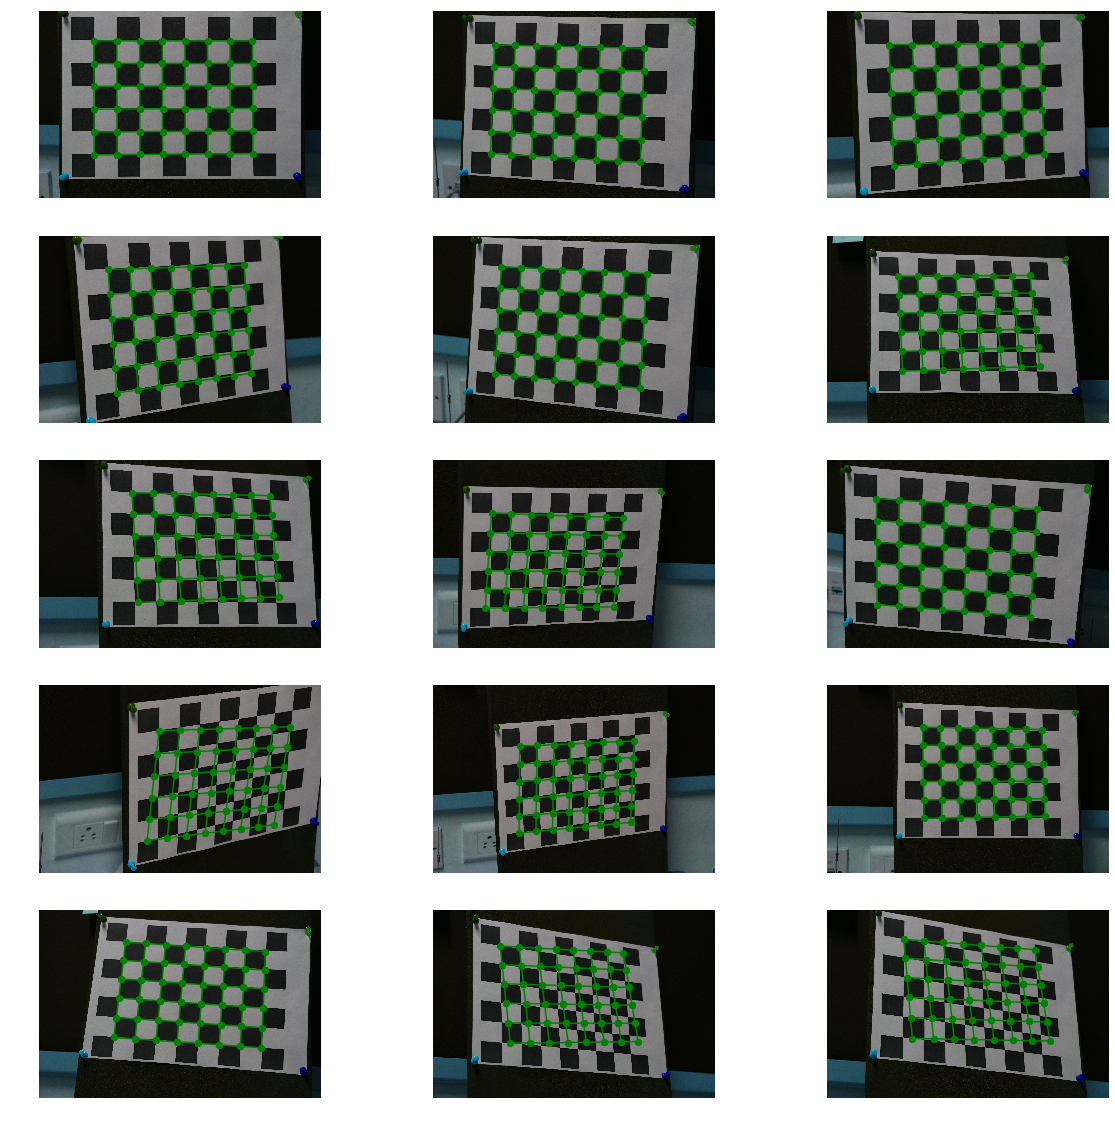

In [18]:
# Defining homogenous world coordinates
world_points_1 = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)),np.ones((48,1)))).astype(np.float32)
fig = plt.figure(figsize=(20,20))

for i in range(15):
    im=cv2.imread("./Camera_calibration_data/IMG_54"+str(56+i)+".JPG")
    P = get_projection(mtx,rvecs[i],tvecs[i])

    # Projecting the world points to image 
    projected_points = []
    for j in range(48):
        projection = np.matmul(P,np.transpose(world_points_1[j,:]))
        projection = projection/projection[2]
        projected_points.append(projection[0:2])
    projected_points = np.asarray(projected_points)
    
    ax = fig.add_subplot(5,3,i+1)
    # Wireframe construction
    idx = [7,15,23,31,39,47]
    q = 0
    for i in range(projected_points.shape[0]):
        if (i == idx[q]):
            q = q + 1
            continue
        ax.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'go-')
    for i in range(8):
        i1 = i
        j =  i + 8
        while(j < 48):
            ax.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'go-')
            i1 = j
            j = j + 8
    ax.axis('off')
    ax.imshow(im)

### Observations on the overlay:
When the image is taken from a larger angle the wireframe doesn't fit properly. This could be arising from improper calculation of rotation and translation vectors. For more or less perpendicular images the wireframe fits exactly.

### Image of the world origin

Error in measurement: 11.676145068914117
Error in measurement: 12.810951937159981
Error in measurement: 9.081967405397759
Error in measurement: 6.451663270755288
Error in measurement: 11.916538932996946
Error in measurement: 9.59705259866863
Error in measurement: 4.962284166623533
Error in measurement: 13.3444548190461
Error in measurement: 13.193300300481763
Error in measurement: 1.84338191739301
Error in measurement: 8.596869781074624
Error in measurement: 6.655088724503771
Error in measurement: 8.288691332174492
Error in measurement: 8.699495333855285
Error in measurement: 6.224251026907549


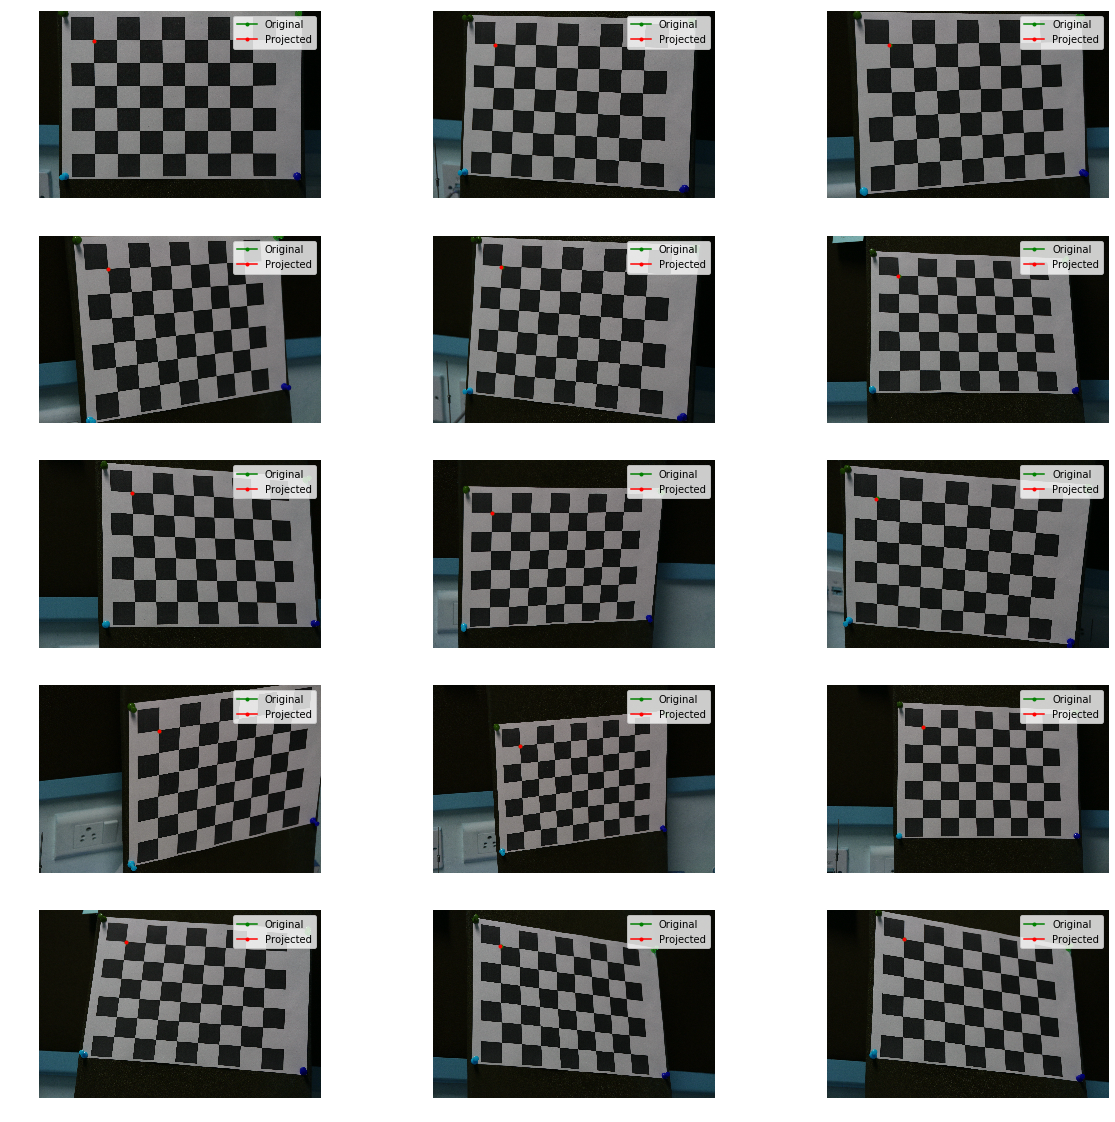

In [19]:
world_origin = np.array([0,0,0,1])
fig = plt.figure(figsize=(20,20))
for i in range(15):
    P = get_projection(mtx,rvecs[i],tvecs[i])
    x = P @ world_origin
    im=cv2.imread("./Camera_calibration_data/IMG_54"+str(56+i)+".JPG")
    ret, corners = cv2.findChessboardCorners(im, (8,6))
    
    ax = fig.add_subplot(5,3,i+1)
    ax.plot(corners[0][0][0],corners[0][0][1],'-go',label='Original',markersize=3)
    ax.plot(x[0],x[1],'-ro',label='Projected',markersize=3)
    print("Error in measurement:",np.linalg.norm(corners[0][0][:2]-x[:2]))
    ax.axis('off')
    ax.imshow(im)
    ax.legend()

### Observation: 
We notice that the projection of the world origin always coincides with the corresponding point in the image coordinates (within some margin of error). The image of the world origin is the fourth column of the projection matrix P=K[R|t]

# Question 3

## DLT using calibration object

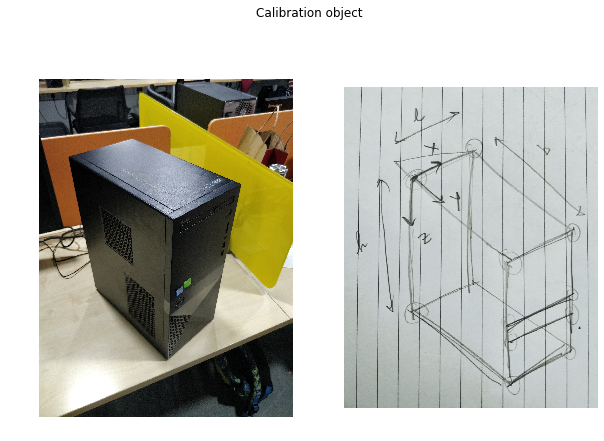

In [20]:
# Displaying the calibration object       
im=cv2.cvtColor(cv2.imread("./data/q3.jpg"),cv2.COLOR_BGR2RGB)
ref = cv2.cvtColor(cv2.imread("./data/ref.jpg"),cv2.COLOR_BGR2RGB)
 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 7))
fig.suptitle('Calibration object')
ax1.imshow(im)
ax1.axis('off')
ax2.imshow(ref)
ax2.axis('off')
plt.show()

### Defining 3D-2D correspondences

In [21]:
l = 0.179
b = 0.289
h = 0.373
x = 0.179
y = 0.034
wp = np.array([[0,b,0],
               [0,b,x],
               [0,b,x+y],
               [0,b,h],
               [l,b,0],
               [l,b,h],
               [l,b,x+y],
               [l,b,x],
               [l,0,0],
               [0,0,0],
               [0,0,h]]
             )
cp = np.array([[1827,1932],
               [1780,3065],
               [1775,3227],
               [1749,3838],
               [2747,1439],
               [2375,3269],
               [2493,2662],
               [2524,2513],
               [1278,821],
               [405,1068],
               [767,2840]])

### Using DLT to calibrate to get Projection Matrix and decomposing it to get K,R,X0

In [22]:
P = calibrateDLT(wp,cp)
print("Projection Matrix:",P)
k,r,x = calculate_RTX(P)
print("Camera Matrix:",k/k[2][2])
print("Rotation Matrix:",r)
print("Camera Center:",x)

Projection Matrix: [[ 6.03592482e+03  3.07291430e+03  1.86313366e+03  4.01960374e+02]
 [-6.55779965e+02  1.01760368e+03  8.01067095e+03  1.06876140e+03]
 [ 8.84620403e-01 -1.01829060e+00  1.14968276e+00  1.00000000e+00]]
Camera Matrix: [[-3.70182411e+03 -2.93148577e+02  1.38556617e+03]
 [-0.00000000e+00 -3.87964003e+03  2.41732532e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation Matrix: [[-0.76534056 -0.64334292  0.0190712 ]
 [ 0.4063636  -0.50597653 -0.76082612]
 [ 0.49912167 -0.57454125  0.6486755 ]]
Camera Center: [-0.2584605   0.50985938 -0.2193436 ]


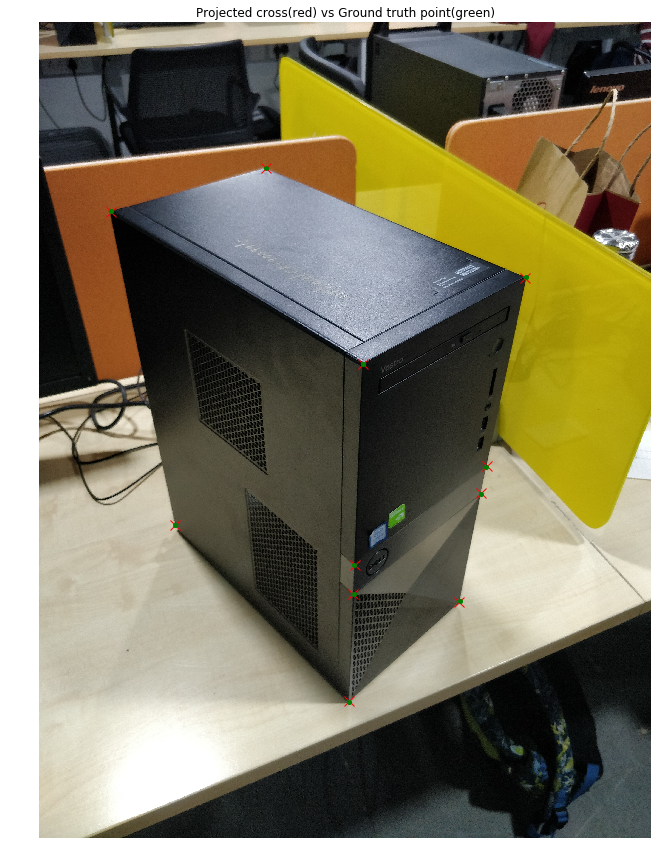

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(cv2.imread("./data/q3.jpg"),cv2.COLOR_BGR2RGB))
for i in range(wp.shape[0]):
    proj = P @ np.append(wp[i],1).T
    proj = proj/proj[2]
    cc = cp[i]
    plt.plot(proj[0],proj[1], 'rx',markersize=10)
    plt.plot(cc[0],cc[1],'go',markersize=4)
plt.axis('off')
plt.title("Projected cross(red) vs Ground truth point(green)")
plt.show() 

## Zhang's method using our checkerboard

Reprojection Error: 0.997737666918696
Camera Calibration Matrix:
[[1.58716478e+03 0.00000000e+00 1.01889489e+03]
 [0.00000000e+00 1.59851367e+03 7.50674792e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 0.14995276 -0.71810573  0.00155887  0.00939553  1.10308012]]
Rotation Matrix for frame 1: [[-0.99991047 -0.00476376 -0.01250399]
 [ 0.00545429 -0.99842792 -0.05578473]
 [-0.01221859 -0.05584793  0.99836452]]


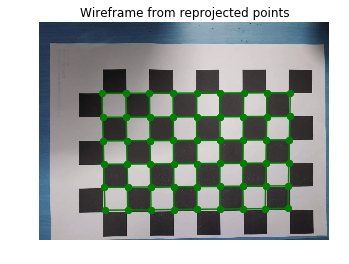

In [24]:
_3d_points=[]
_2d_points=[]
x,y=np.meshgrid(range(9),range(6))
world_points=np.hstack((x.reshape(54,1),y.reshape(54,1),np.zeros((54,1)))).astype(np.float32)

for i in range(1,6):
    im=cv2.imread("./data/"+str(i)+".jpeg")
    
    ret, corners = cv2.findChessboardCorners(im, (9,6))
    
    if ret: #add points only if checkerboard was correctly detected:
        _2d_points.append(corners) 
        _3d_points.append(world_points) 

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
# print('Rotation Vectors for the images are:')
# print(rvecs)
# print('Translation Vectors for the images are:')
# print(tvecs)

r =  rvecs[2]
R = (eulerAnglesToRotationMatrix(r))
print("Rotation Matrix for frame 1:",R)

# Making homogenous world coordinates with Z=0
world_points_1 = np.hstack((x.reshape(54,1),y.reshape(54,1),np.zeros((54,1)),np.ones((54,1)))).astype(np.float32)

# Construction of P matrix from R and t
temp1 = np.zeros((3,4))
temp1[0:3,0:3] = R[0:3,0:3]
temp1[:,3] = tvecs[2][:,0]
P = np.matmul(mtx,temp1)
P = P/P[2,3]

# Projecting the world points to image 
projected_points = []
for i in range(54):
    projection = np.matmul(P,np.transpose(world_points_1[i,:]))
    projection = projection/projection[2]
    projected_points.append(projection[0:2])
projected_points = np.asarray(projected_points)

# Wireframe construction
idx = [8,17,26,35,44,53]
q = 0
for i in range(projected_points.shape[0]):
    if (i == idx[q]):
        q = q + 1
        continue
    plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'go-')
for i in range(9):
    i1 = i
    j =  i + 9
    while(j < 54):
        plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'go-')
        i1 = j
        j = j + 9

# Placing the wireframe over the image and displaying        
im=cv2.imread("./data/3.jpeg")
plt.imshow(im)
plt.title('Wireframe from reprojected points')
plt.axis('off')
plt.show() 

## Varying focus 

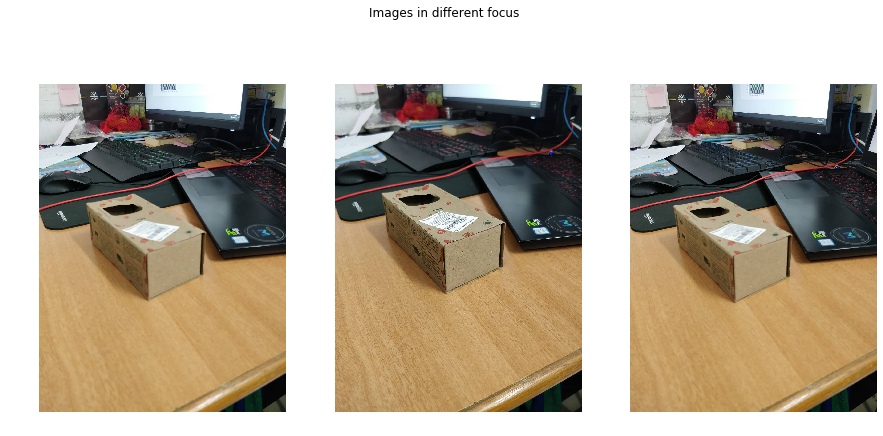

In [25]:
f1 = cv2.cvtColor(cv2.imread("./data/f1.jpg"),cv2.COLOR_BGR2RGB)
f2 = cv2.cvtColor(cv2.imread("./data/f2.jpg"),cv2.COLOR_BGR2RGB)
f3 = cv2.cvtColor(cv2.imread("./data/f3.jpg"),cv2.COLOR_BGR2RGB)

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15, 7))
fig.suptitle('Images in different focus')
ax1.imshow(f1)
ax1.axis('off')
ax2.imshow(f2)
ax2.axis('off')
ax3.imshow(f3)
ax3.axis('off')
plt.show()

In [26]:
l = 15.5
b = 7
h = 5.5
wp = np.array([[0,0,0],
              [l,0,0],
              [l,0,h],
              [l,b,h],
              [l,b,0],
              [0,b,0],
              [0,b,h]])
cp1 = np.array([[495,578],
               [875,783],
               [862,1006],
               [576,1142],
               [565,899],
               [248,633],
               [275,833]])
cp2 = np.array([[501,525],
               [894,734],
               [881,966],
               [583,1105],
               [571,850],
               [244,579],
               [274,788]])
cp3 = np.array([[476,592],
                [853,797],
                [839,1016],
                [552,1154],
                [544,908],
                [227,645],
                [252,843]])

P1 = calibrateDLT(wp,cp1)
k1,_,_ = calculate_RTX(P1)
print("Camera Matrix:",k1/k1[2][2])

P2 = calibrateDLT(wp,cp2)
k2,_,_ = calculate_RTX(P2)
print("Camera Matrix:",k2/k2[2][2])

P3 = calibrateDLT(wp,cp3)
k3,_,_ = calculate_RTX(P3)
print("Camera Matrix:",k3/k3[2][2])

Camera Matrix: [[-1.46718440e+03  3.88444210e+01  7.06216621e+02]
 [-0.00000000e+00 -1.45871141e+03  7.99801095e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Camera Matrix: [[-1.48910219e+03  3.11426627e+01  7.31586156e+02]
 [-0.00000000e+00 -1.48108279e+03  7.83380426e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Camera Matrix: [[-1.44583761e+03  3.91479659e+01  7.25976520e+02]
 [-0.00000000e+00 -1.42674611e+03  7.66531755e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Observation :
The focal length depends on the distance of the object we are focusing at. The objects farther away are focused at smaller focal length and vice versa.
In our example we focus at three different distances. The focal length does not vary a lot due to physical limitations of the camera and the proximity of the objects being focused at. 
